# Multi-Class Prediction of Obesity Risk

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Carregando os Dados

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Salvar id para auxiliar na criação do arquivo que será enviado ao Kaggle
test_id = test['id']

# Criando um DF novo com o train e o test
df = pd.concat([train, test], ignore_index=True).drop('id', axis = 1)

# Para auxiliar no momento separar o DF em train e test
split_index = len(train)

# Variável alvo
target = df['NObeyesdad']
target_name = 'NObeyesdad'

## Análise Exploratória (EDA)

In [4]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000,34598.000000
mean,23.886181,1.699721,87.686451,2.444704,2.757043,2.030469,0.978861,0.614467
std,5.733207,0.087895,26.273493,0.532568,0.707610,0.609566,0.839122,0.604475
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.784710,0.006892,0.000000
50%,22.851747,1.700000,84.000000,2.392179,3.000000,2.000000,1.000000,0.555591
75%,26.000000,1.761773,111.539494,3.000000,3.000000,2.550570,1.583832,1.000000
max,61.000000,1.980000,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34598 entries, 0 to 34597
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          34598 non-null  object 
 1   Age                             34598 non-null  float64
 2   Height                          34598 non-null  float64
 3   Weight                          34598 non-null  float64
 4   family_history_with_overweight  34598 non-null  object 
 5   FAVC                            34598 non-null  object 
 6   FCVC                            34598 non-null  float64
 7   NCP                             34598 non-null  float64
 8   CAEC                            34598 non-null  object 
 9   SMOKE                           34598 non-null  object 
 10  CH2O                            34598 non-null  float64
 11  SCC                             34598 non-null  object 
 12  FAF                             

In [7]:
df.nunique()

Gender                               2
Age                               1934
Height                            2070
Weight                            2318
family_history_with_overweight       2
FAVC                                 2
FCVC                              1054
NCP                                793
CAEC                                 4
SMOKE                                2
CH2O                              1734
SCC                                  2
FAF                               1539
TUE                               1436
CALC                                 4
MTRANS                               5
NObeyesdad                           7
dtype: int64

### Verificação de Nulos

In [8]:
columns_sum_nulls = df.isnull().sum()
columns_with_nulls = columns_sum_nulls[columns_sum_nulls > 0]
columns_with_nulls

NObeyesdad    13840
dtype: int64

### Análise de Correlação

In [9]:
numerical_data = df.select_dtypes(include=['float64', 'int64'])
categorical_data = df.select_dtypes(include=['object'])

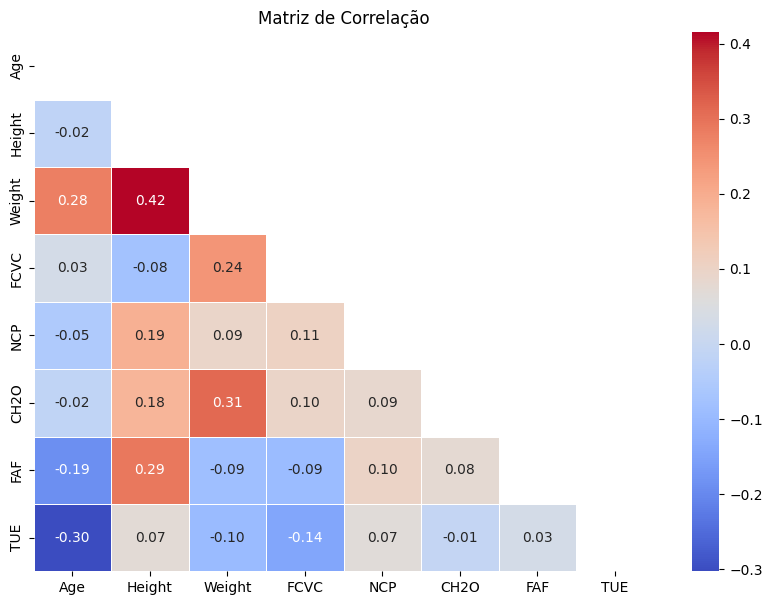

In [10]:
# Matriz de correlação
matriz_corr = numerical_data.corr()

# Plotar heatmap
plt.figure(figsize=(10, 7))
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
sns.heatmap(matriz_corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

In [11]:
%pip install association_metrics

Note: you may need to restart the kernel to use updated packages.


In [16]:
# Import association_metrics  
import association_metrics as am
# Convert you str columns to Category columns
df = df.apply(
        lambda x: x.astype("category") if x.dtype == "O" else x)

# Initialize a CamresV object using you pandas.DataFrame
cramersv = am.CramersV(df) 
# will return a pairwise matrix filled with Cramer's V, where columns and index are 
# the categorical variables of the passed pandas.DataFrame
cramersv.fit()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
Gender,1.000000,0.098913,0.022441,0.074535,0.065381,0.059496,0.086237,0.152555,0.619004
family_history_with_overweight,0.098913,1.000000,0.151492,0.332593,0.017214,0.170507,0.009778,0.125480,0.556272
FAVC,0.022441,0.151492,1.000000,0.137244,0.019246,0.108906,0.114248,0.115920,0.273578
CAEC,0.074535,0.332593,0.137244,1.000000,0.029702,0.127772,0.079889,0.068360,0.332803
SMOKE,0.065381,0.017214,0.019246,0.029702,1.000000,0.020281,0.021024,0.032557,0.102079
SCC,0.059496,0.170507,0.108906,0.127772,0.020281,1.000000,0.011328,0.048256,0.222191
CALC,0.086237,0.009778,0.114248,0.079889,0.021024,0.011328,1.000000,0.064010,0.310908
MTRANS,0.152555,0.125480,0.115920,0.068360,0.032557,0.048256,0.064010,1.000000,0.168200
NObeyesdad,0.619004,0.556272,0.273578,0.332803,0.102079,0.222191,0.310908,0.168200,1.000000


### Análise de Relações com a Variável Target

In [ ]:

for field in categorical_data.drop(target_name, axis=1):
    # Tabela de contingência
    contingency_table = pd.crosstab(index=df[field][:split_index], columns=df[target_name][:split_index])
    
    # Teste Chi-quadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'{field} x {target_name}')
    print("P-value:", p)
    print()

Gender x NObeyesdad
P-value: 0.0

family_history_with_overweight x NObeyesdad
P-value: 0.0

FAVC x NObeyesdad
P-value: 0.0

CAEC x NObeyesdad
P-value: 0.0

SMOKE x NObeyesdad
P-value: 6.396981747148517e-44

SCC x NObeyesdad
P-value: 3.8701029544793576e-218

CALC x NObeyesdad
P-value: 0.0

MTRANS x NObeyesdad
P-value: 0.0



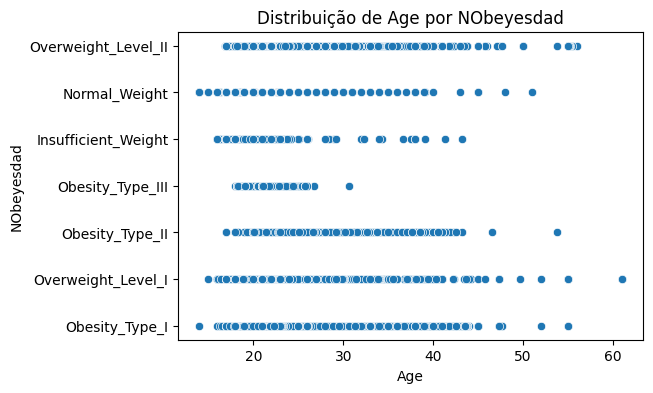

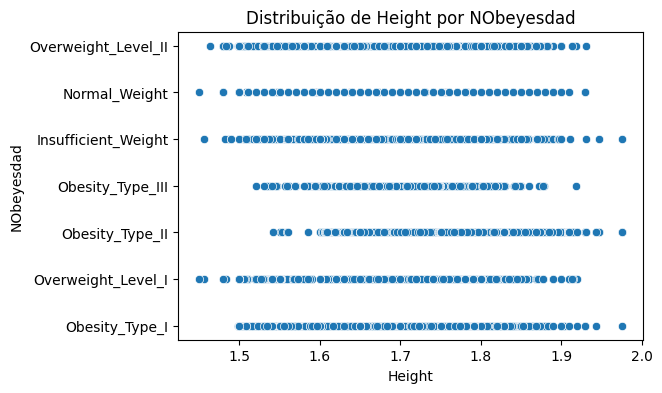

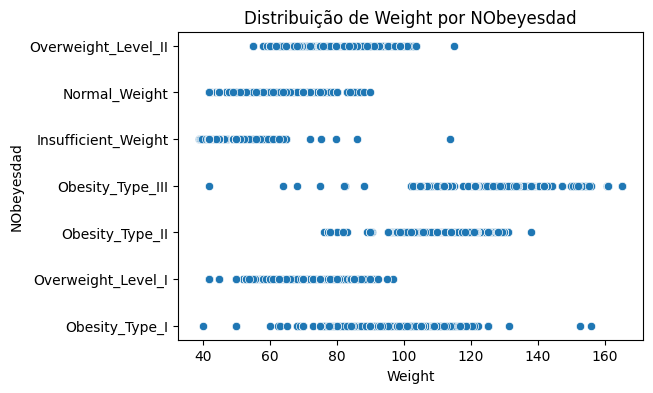

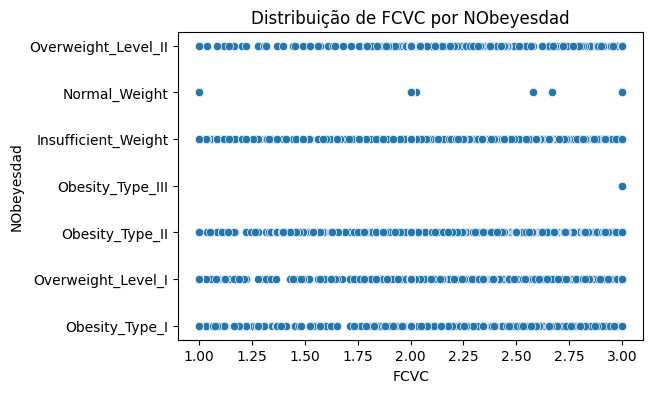

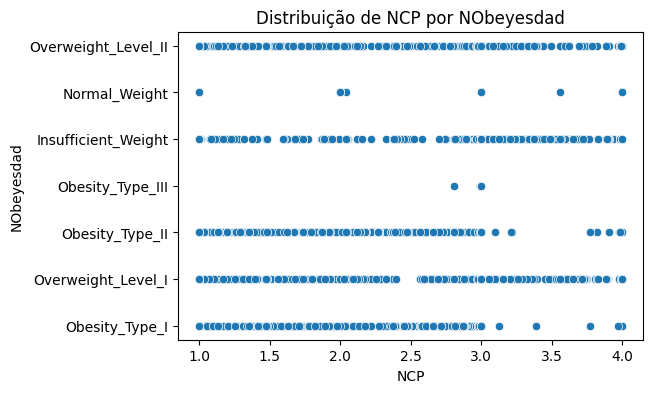

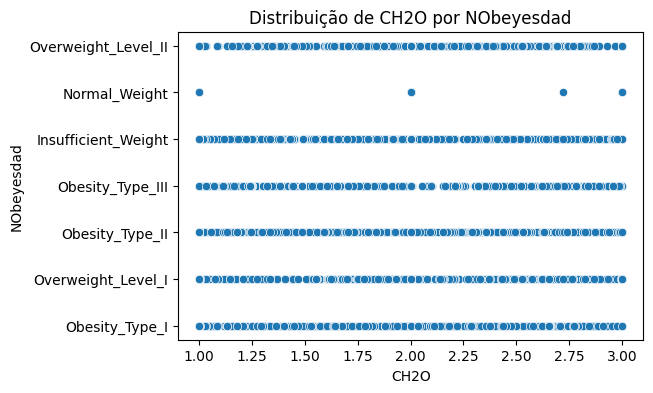

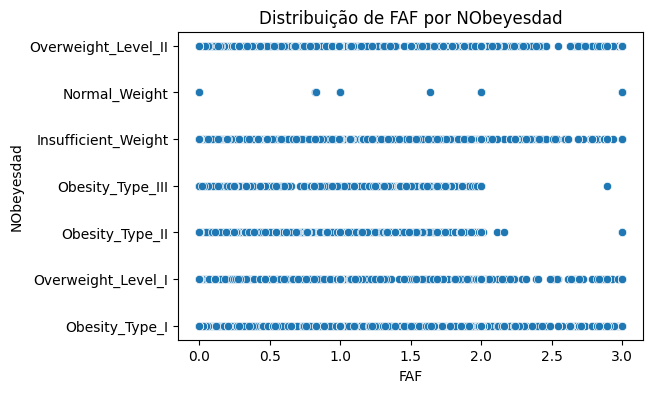

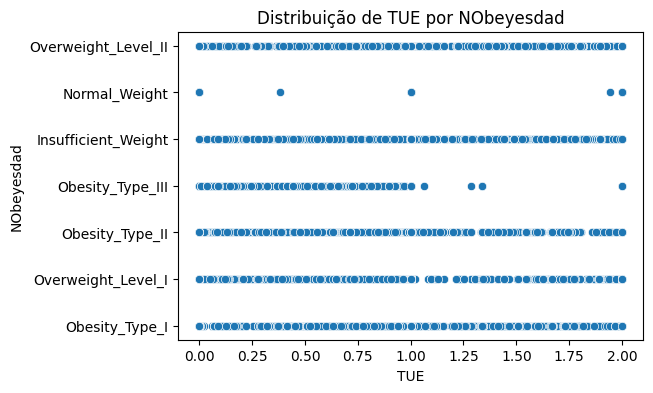

In [ ]:
# Gráficos de dispersão
for field in numerical_data:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=field, y=target, data=df)
    plt.title(f'Distribuição de {field} por {target}')
    plt.show()

## Feature Engineering

In [ ]:
df['IMC'] = df['Weight'] / ( df['Height'] * df['Height'] )
df = df.drop(['Height', 'Weight'], axis=1)

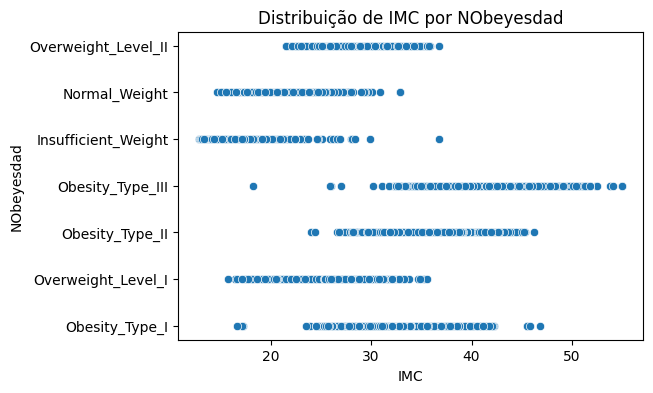

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='IMC', y=target, data=df)
plt.title(f'Distribuição de IMC por {target}')
plt.show()

## Comparação com Naive Bayes

In [ ]:
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,IMC
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34593,Male,23.327836,1.721384,78.030383,yes,no,2.813234,3.000000,Sometimes,no,1.000000,no,0.807076,0.778632,Sometimes,Public_Transportation,NaN,26.333478
34594,Female,29.000000,1.590000,62.000000,no,yes,3.000000,3.000000,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,NaN,24.524346
34595,Female,22.935612,1.585547,44.376637,no,yes,3.000000,2.273740,Frequently,no,2.000000,no,1.949840,1.000000,Sometimes,Public_Transportation,NaN,17.652091
34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.000000,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation,NaN,20.195092


## Matriz de Confusão

## Gerando Arquivo de Resultados para o Kaggle